## Preprocessing of the dataset by Bradley et al.

In [2]:
import sys, os, re
import pandas as pd
import numpy as np
from rdkit import Chem, rdBase
from rdkit.Chem import rdFMCS, Draw, PandasTools, rdDepictor, Descriptors
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from IPython.display import SVG
try:
    import arthor
except ImportError:
    arthor = None
    
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import ast
import random
from ipywidgets import interact,fixed,IntSlider

print('RDKit version: ',rdBase.rdkitVersion)
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('MatplotLib version:', mpl.__version__)
# print('Arthor version:', arthor.__version__)

RDKit version:  2020.03.4
Pandas version: 1.0.3
Numpy version: 1.19.0
MatplotLib version: 3.2.2


In [3]:
from automated_series_classification import utilsStructureEval, utilsDrawing

### Load dataset by Bradley et al. and select all compounds which were synthesized and screened for this project ("synscreen")

In [4]:
proj='CDK2Kinase'

In [6]:
df = pd.read_excel('./data/jm020472j_s2.xls'.format(proj))
df['ID']=df.index
df.head()

,Smiles,mol_name,cdk2_ic50,cdk2_inhib,scaffold,sourcepool,cdk_act_bin_1,ID
0,C#CC(/C=C/C)OC(=O)c(ccc1)c(c1)C(=O)O,mol_1,None,23.3,Scaffold_00,divscreen,0,0
1,C#CC(C)(C)N(CC1C)CC\C1=N\OC(=O)c2cc([N+]([O-])...,mol_2,None,20.5,Scaffold_00,divscreen,0,1
2,C#CC(C)(C)N(CN1)CNC1=S,mol_3,None,20.7,Scaffold_00,divscreen,0,2
3,C#CC(C)(C)N(CN1)C\N=C/1SC,mol_4,None,1.9,Scaffold_00,divscreen,0,3
4,C#CC(C)(C)NC(=O)CN(c(c1)cccc1)[S](=O)(=O)c2ccc...,mol_5,None,19.8,Scaffold_00,divscreen,0,4


/Users/cthoyt/.virtualenvs/integrator/lib/python3.8/site-packages/rdkit/Chem/PandasTools.py:416: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,Smiles,mol_name,cdk2_ic50,cdk2_inhib,scaffold,sourcepool,cdk_act_bin_1,ID,Molecule
29,C#CCNc(cc1)nc(n1)NC(C)(C)C(=O)OC,mol_30,None,53.17,Scaffold_05,synscreen,100,29,
30,C#CCNc(n1)c(C)cnc1Nc(cc2C)c(Cl)cc2,mol_31,None,54.76,Scaffold_05,synscreen,100,30,
31,C#CCNc(n1)cc(C)nc1Nc(cc2)c(CO)cc2C,mol_32,None,36.15,Scaffold_05,synscreen,50,31,
32,C#CCNc(n1)ccnc1Nc(cc2)c(C)c(c2)F,mol_33,None,36.05,Scaffold_05,synscreen,50,32,
33,C#CCNc(n1)ncc(C)c1Nc(cc2C)c(O)cc2,mol_34,None,45.74,Scaffold_05,synscreen,50,33,

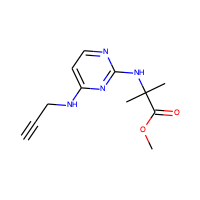
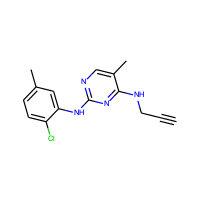
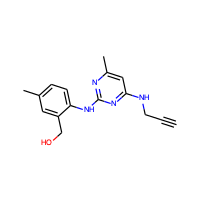
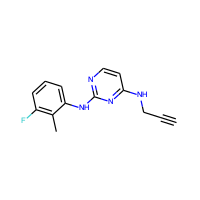
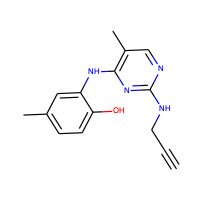

In [7]:
synscreen = df.loc[df.sourcepool=='synscreen']
PandasTools.AddMoleculeColumnToFrame(synscreen,'Smiles','Molecule')
synscreen=synscreen.loc[synscreen['Molecule'].map(lambda x: x is not None)]
synscreen.head()

In [ ]:
len(synscreen.loc[synscreen['cdk2_inhib'].map(lambda x: x=='None')])

In [ ]:
len(synscreen)

Sort out all series (scaffold and assigned molecules) below the size limit

In [ ]:
sizelimit=20
scafs=list(set(synscreen['scaffold'].tolist()))
scafs.sort()
scafs_sel=[s for s in scafs if synscreen['Molecule'].loc[synscreen['scaffold']==s].count()>=sizelimit]
synscreen_sel=synscreen.loc[synscreen['scaffold'].map(lambda x: x in scafs_sel)]

### Load and prepare ChEMBL25 database

In [ ]:
if not os.path.isdir('./arthor/'.format(proj)):
    os.mkdir('./arthor/'.format(proj))

In [ ]:
os.system('smi2atdb -j 0 -t ./chembl_25.smi ./arthor/chembl_25.atdb')
os.system('atdb2fp -j 0 ./arthor/chembl_25.atdb')

In [ ]:
chembldb=arthor.SubDb('./arthor/chembl_25.atdb')
Nchembl=len(chembldb.search('*'))
print(Nchembl)

### Calculate MCS from original series assignment by Bradley et al. 

Note that forig and fsampled corresponds to the expected match probabilities E(p) as described in the paper

In [ ]:
MCSorig=[]
forig=[]
assignedmols=[]
Nmolsorig=[]
for scaf in scafs_sel:
    mollist=synscreen['Molecule'].loc[synscreen['scaffold']==scaf].tolist()
    fChembl,MCS=utilsStructureEval.MCSFromMollist(mollist,chembldb,Nchembl)
    forig.append(fChembl)
    assignedmols.append(synscreen['ID'].loc[synscreen['scaffold']==scaf].tolist())
    Nmolsorig.append(len(synscreen['ID'].loc[synscreen['scaffold']==scaf].tolist()))
    MCSorig.append(MCS)

In [ ]:
def renderMCS(series,scafslist,MCSList,fChemblList):
    listid=np.where(np.array(scafslist)==series)[0][0]
    svg=utilsDrawing.moltosvg(Chem.MolFromSmarts(MCSList[listid]), molSize=(450,250))
    label='{0}, {1:.2E}'.format(scafslist[listid],fChemblList[listid])
    svgGrid = utilsDrawing.SvgsToGrid([svg], labels=[label], svgsPerRow=1, molSize=(450,250))
    
    return(display(SVG(svgGrid)))

In [ ]:
interact(renderMCS, series=scafs_sel, scafslist=fixed(scafs_sel), MCSList=fixed(MCSorig),fChemblList=fixed(forig));

### Determine MCS from sampling

In [ ]:
Nsample=100
frac_sample=0.8
inv_sample=1/frac_sample

In [ ]:
MCSsampled=[]
fsampled=[]

for scaf in scafs_sel:
    fi=[]
    MCSi=[]
    samplerange=synscreen['ID'].loc[synscreen['scaffold']==scaf].tolist()
    for i in range(Nsample):
        random.seed(i+1)
        molinds=random.sample(population=samplerange,k=int(len(samplerange)//inv_sample))
        samplemols=synscreen['Molecule'].loc[synscreen['ID'].map(lambda x: x in molinds)].tolist()
        fChembl,MCS=utilsStructureEval.MCSFromMollist(samplemols,chembldb,Nchembl)
        fi.append(fChembl)
        MCSi.append(MCS)
    ind=np.argmin(np.array(fi))
    fsampled.append(fi[ind])
    MCSsampled.append(MCSi[ind])

In [ ]:
interact(renderMCS, series=scafs_sel, scafslist=fixed(scafs_sel), MCSList=fixed(MCSsampled),fChemblList=fixed(fsampled));

### Assign molecules to "sampled" MCS

In [ ]:
df_arthor=synscreen_sel[['Smiles','ID']]
df_arthor.to_csv('./arthor/{0}.smi'.format(proj), header=None, index=None, sep=' ')
os.system('smi2atdb -j 0 -t ./arthor/{0}.smi ./arthor/{0}.atdb'.format(proj))
os.system('atdb2fp -j 0 ./arthor/{0}.atdb'.format(proj))
proj_db=arthor.SubDb('./arthor/{0}.atdb'.format(proj))

matches=[]
Nmolssampled=[]
synscreen_sel['series assignment'] = [list() for x in range(len(synscreen_sel.index))]
for ind in range(len(scafs_sel)):
    res=proj_db.search(MCSsampled[ind])
    reslist=[int(r.decode('utf-8')) for r in res]
    synscreen_sel['series assignment'].loc[synscreen_sel['ID'].map(lambda x: x in reslist)].apply(lambda x : x.append(scafs_sel[ind]))
    matches.append(reslist)
    Nmolssampled.append(len(reslist))

In [ ]:
df_scafs=pd.DataFrame({'ScafName':scafs_sel,'MCSorig':MCSorig,'forig':forig,'mols orig':assignedmols,'N orig':Nmolsorig,'MCSsampled':MCSsampled,'fsampled':fsampled,'mols sampled':matches,'N sampled':Nmolssampled})

### Calculate precision and recall of "sampled" series w.r.t. original series

In [ ]:
recall=[]
precision=[]
for i in range(len(matches)):
    intersect=list(set(matches[i])&set(assignedmols[i]))
    recall.append(len(intersect)/len(assignedmols[i]))
    precision.append(len(intersect)/len(matches[i]))
    
df_scafs['recall']=recall
df_scafs['precision']=precision


### save series data and mol data

In [ ]:
df_scafs

In [ ]:
synscreen_sel.head()

In [ ]:
if not os.path.isdir('./{0}/'.format(proj)):
    os.mkdir('./{0}/'.format(proj))

In [ ]:
df_scafs.to_csv('./{0}/seriesdata.csv'.format(proj))

Fro Butina clustering: prepare "assay" column. Higher activity has to correspond to lower values. Here 'cdk2_inib' chosen as relevant assay.

In [ ]:
mininhib=min(synscreen_sel['cdk2_inhib'].loc[synscreen_sel['cdk2_inhib']!='None'].tolist())
synscreen_sel=synscreen_sel.replace({'cdk2_inhib':'None'},mininhib)
synscreen_sel['assay']=synscreen_sel['cdk2_inhib'].map(lambda x: -x)
synscreen_sel.head()

In [ ]:
synscreen_sel[['ID','Smiles','mol_name','scaffold','series assignment','assay']].to_csv('./{0}/moldata_preprocessed.csv'.format(proj))